In [138]:
import os
import h5py
import math
import numpy as np
import pandas as pd
import glob
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

In [3]:
#Importing library tensorflow to operate on  model

import tensorflow as tf
import tensorflow_datasets as tfds


import keras, os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras import backend
from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.models import load_model

In [2]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Mounting Google drive 

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
###Preparing dictionary for image labels 

label_map = {0:'Normal', 
             1:'Atelectasis',
             2:'Calcification', 
             3:'Consolidation', 
             4:'Effusion', 
             5:'Emphysema', 
             6:'Fibrosis', 
             7:'Fracture', 
             8:'Mass', 
             9: 'Nodule', 
             10:'Pneumothorax'}

rev_label_map = {v: k for k, v in label_map.items()}

In [8]:
###Mapping the train dataset labels with index and classes

##For mapping, we use json file of labels that were a part of our dataset

#In these steps, we first created a dataframe of train labels from json file and then created an array of those labels called y_train


with open('/content/drive/MyDrive/train.json') as user_file:
    file_contents = user_file.read()
parsed_json = json.loads(file_contents)

class_list = []
file_list = []
for i in parsed_json:
    class_list.append(list(set(i['syms'])))
    file_list.append(i['file_name'])

for i in class_list:
    if len(i)==0:
        i.append(label_map[0])


df = pd.DataFrame(data=class_list)
df['label'] = pd.Series(class_list)
df = df['label']
df_process = pd.get_dummies(df.apply(pd.Series).stack()).sum(level=0)
df_process['file_name'] = pd.Series(file_list)
df_clean=df_process.drop('file_name',axis = 1)
y_train = np.array(df_clean)
len(y_train)

<ipython-input-8-7fc2b8502d92>:26: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_process = pd.get_dummies(df.apply(pd.Series).stack()).sum(level=0)


3001

In [9]:
#Depiction of how the array of labels look like 

y_train[:10] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [6]:
###Mapping the test dataset labels with index and classes

##For mapping, we use json file of labels that were a part of our dataset

#In these steps, we first created a dataframe of test labels from json file and then created an array of those labels called y_test 

with open('/content/drive/MyDrive/test.json') as user_file:
    file_contents = user_file.read()
parsed_test_json = json.loads(file_contents)

test_class_list = []
test_file_list = []
for i in parsed_test_json:
    test_class_list.append(list(set(i['syms'])))
    test_file_list.append(i['file_name'])


for i in test_class_list:
    if len(i)==0:
        i.append(label_map[0])

test_df = pd.DataFrame(data=test_class_list)
test_df['label'] = pd.Series(test_class_list)
test_df = test_df['label']
test_df_process = pd.get_dummies(test_df.apply(pd.Series).stack()).sum(level=0)
test_df_process['file_name'] = pd.Series(test_file_list)
test_df_clean=test_df_process.drop('file_name',axis = 1)
y_test = np.array(test_df_clean)
len(y_test)

<ipython-input-6-e35d70279e09>:25: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  test_df_process = pd.get_dummies(test_df.apply(pd.Series).stack()).sum(level=0)


542

In [7]:
#Depiction of how the array of labels look like 

y_test[:10] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=uint8)

In [10]:
#We converted the .jpg images of test and train data into a numpy array file for the ease of processing in computer vision models 

train_data = np.load('/content/drive/MyDrive/xray/train_image.npy', encoding='bytes')
test_data = np.load('/content/drive/MyDrive/xray/test_image.npy', encoding='bytes')

In [11]:
#Checking the shape of training data 

train_data.shape

(3001, 1024, 1024)

In [12]:
#Checking the shape of testing data 

test_data.shape

(542, 1024, 1024)

In [13]:
#Reshaping the training dataset to reduce their size from 1024 to 224 and from 3-dimensional to 4-dimensional 

train_new = np.zeros((3001, 300, 300, 1))
for i in range(3001):
  train_new[i] = np.reshape(cv2.resize(train_data[i], (300,300)), (300,300,1))

In [14]:
#Checking new shape of training dataset 

train_new.shape

(3001, 300, 300, 1)

In [15]:
#Reshaping the testing dataset to reduce their size from 1024 to 224 and from 3-dimensional to 4-dimensional 

test_new = np.zeros((542,  300, 300, 1))
for i in range(542):
  test_new[i] = np.reshape(cv2.resize(test_data[i], (300,300)), (300,300,1))

In [16]:
#Checking new shape of testing dataset 

test_new.shape

(542, 300, 300, 1)

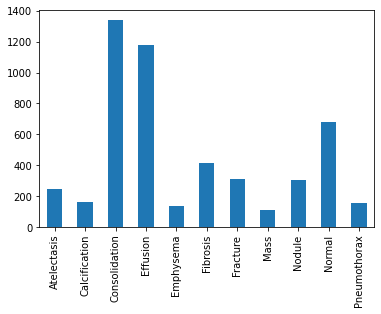

In [17]:
#Visualize training data label imbalances
df_train_sum = df_clean.sum(axis=0)
df_train_sum.plot(kind='bar')

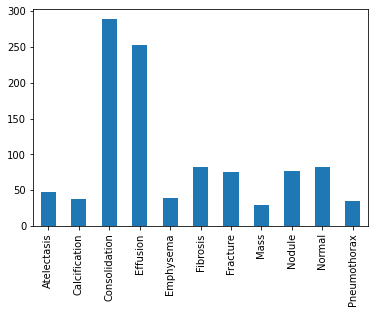

In [18]:
#Visualize testing data label imbalances
df_test_sum = test_df_clean.sum(axis=0)
df_test_sum.plot(kind='bar')

In [19]:
#stratifying data while splitting train and validation data
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_val, y_val = iterative_train_test_split(train_new, y_train, test_size = 0.1)

In [20]:
#Implementing convolutional block for resnet50
def identity_block(X, f, filters, stage, block):

  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  f1, f2, f3 = filters

  bn_axis = 3

  X_skip_connection = X

  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)
 
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

In [21]:
#Implementing convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'
    
    f1, f2, f3 = filters
    
    bn_axis = 3

    X_skip_connection = X


    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

In [22]:
# Setting up ResNet50 with layers
def ResNet50(input_shape = (300, 300, 1), classes = 11):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(1024, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [23]:
#Setting up and compiling the model
model = ResNet50(input_shape = (300, 300, 1), classes = 11)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])

In [24]:
# Normalizing and augmenting the data
aug = ImageDataGenerator(horizontal_flip=True, rotation_range=10, featurewise_center=True, featurewise_std_normalization=True,  fill_mode="nearest")
aug.fit(X_train)

In [26]:
# Training Resnet50 model by feeding label dataset through "aug" for fitting the model to get training and validation accuracy per epoch

batch_size=32
model.fit(x=aug.flow(X_train, y_train, batch_size=32),validation_data=(X_val, y_val), steps_per_epoch = len(X_train)//batch_size, epochs = 10)


Epoch 1/10
84/84 [==============================] - 3453s 41s/step - loss: 0.9819 - binary_accuracy: 0.8319 - auc: 0.6910 - val_loss: 15.7461 - val_binary_accuracy: 0.8232 - val_auc: 0.6188
Epoch 2/10
84/84 [==============================] - 3651s 43s/step - loss: 0.4550 - binary_accuracy: 0.8398 - auc: 0.7290 - val_loss: 561.8868 - val_binary_accuracy: 0.8349 - val_auc: 0.5047
Epoch 3/10
84/84 [==============================] - 3717s 44s/step - loss: 0.4047 - binary_accuracy: 0.8373 - auc: 0.7318 - val_loss: 40.4856 - val_binary_accuracy: 0.7895 - val_auc: 0.5246
Epoch 4/10
84/84 [==============================] - 3721s 44s/step - loss: 0.3747 - binary_accuracy: 0.8428 - auc: 0.7500 - val_loss: 74.4624 - val_binary_accuracy: 0.7866 - val_auc: 0.5915
Epoch 5/10
84/84 [==============================] - 3727s 44s/step - loss: 0.3669 - binary_accuracy: 0.8461 - auc: 0.7603 - val_loss: 75.5433 - val_binary_accuracy: 0.8318 - val_auc: 0.5336
Epoch 6/10
84/84 [==============================]

In [56]:
#Fetching probability predictions of each validation and testing images 
val_pred = model.predict(X_val)
np.save('/content/drive/MyDrive/res50_val_out_final.npy', val_pred)  

test_pred = model.predict(test_new)
np.save('/content/drive/MyDrive/res50_test_out_final.npy', test_pred)  

17/17 [==============================] - 137s 8s/step


In [ ]:
#Model Ending